In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [4]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,21788.203125,17821046406
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,21808.101562,23918742607
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,22220.804688,26792596581


In [5]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop([ 'Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2014-12-25 to 2023-02-19
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2976 non-null   float64
 1   High       2976 non-null   float64
 2   Low        2976 non-null   float64
 3   Adj Close  2976 non-null   float64
 4   Volume     2976 non-null   int64  
 5   RSI        2976 non-null   float64
 6   EMA_short  2976 non-null   float64
 7   EMA_long   2976 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.2 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-07,22757.267578,23310.974609,22756.257812,23264.291016,27187964471,64.484885,22542.069704,19903.181588
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,25371367758,60.306257,22579.910536,19963.304694
2023-02-09,22946.566406,22996.437500,21773.974609,21819.039062,32572572185,48.656922,22507.446586,20000.051909
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,27078406594,47.193524,22425.897730,20032.747586
2023-02-11,21651.841797,21891.410156,21618.449219,21870.875000,16356226232,49.330527,22373.038422,20069.146149
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,26792596581,53.052268,22264.266059,20178.212065
2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,32483312909,67.728410,22458.892320,20259.986911


In [6]:
# Split the data into training and test sets
train_df = data[:int(len(data)*0.8)]
test_df = data[int(len(data)*0.8):]
data.shape


(2976, 8)

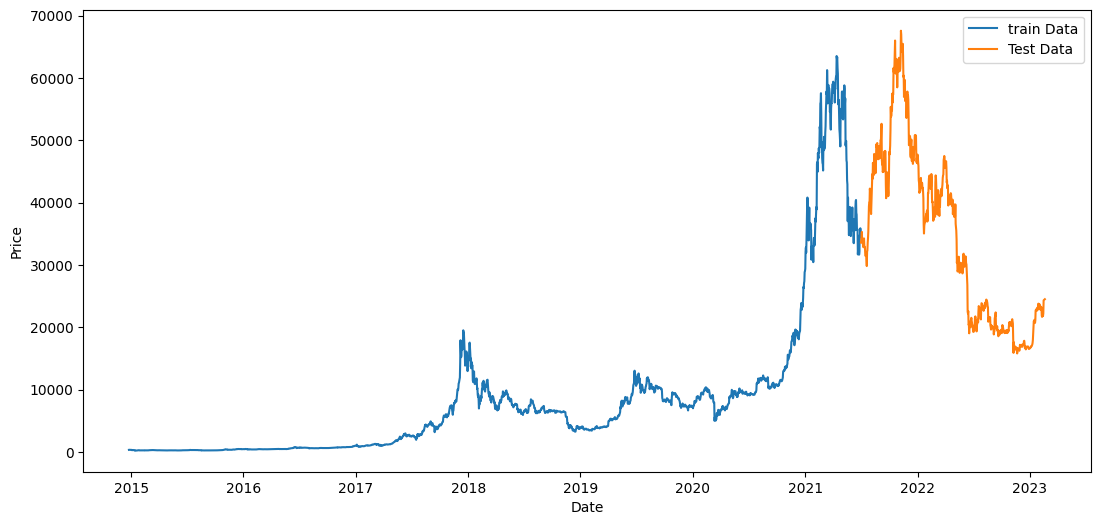

In [7]:
plt.figure(figsize=(13,6))
plt.plot(train_df['Adj Close'], label='train Data')
plt.plot(test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [8]:

train_plot = train_df
train_plot.loc[:, 'type'] = 'Train'
test_plot = test_df
test_plot.loc[:, 'type'] = 'Test'

df = pd.concat([train_plot, test_plot])
df = df.reset_index()
df = df.rename(columns={'index': 'Date'})

fig = px.line(df, x='Date', y='Adj Close', color='type' )
fig.update_layout(title='Train and Test Bitcoin Data',font_size=15, font_color='black',legend_title_text=' Parameters')
fig.show()







C:\Users\pc\AppData\Local\Temp\ipykernel_8164\3946717447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plot.loc[:, 'type'] = 'Train'
C:\Users\pc\AppData\Local\Temp\ipykernel_8164\3946717447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_plot.loc[:, 'type'] = 'Test'


In [9]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()

In [10]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2380 entries, 2014-12-25 to 2021-06-30
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2380 non-null   float64
 1   High       2380 non-null   float64
 2   Low        2380 non-null   float64
 3   Adj Close  2380 non-null   float64
 4   Volume     2380 non-null   int64  
 5   RSI        2380 non-null   float64
 6   EMA_short  2380 non-null   float64
 7   EMA_long   2380 non-null   float64
 8   type       2380 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 185.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2021-07-01 to 2023-02-19
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       596 non-null    float64
 1   High       596 non-null    float64
 2   Low        596 non-null    float64
 3   Adj Close  596 non-null    float64
 4  

In [11]:
# Preprocess the data
X_train = train_df.drop(['Adj Close','type'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close','type'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)



x_train (2380, 7)
y_train (2380,)
X_test (596, 7)
y_test (596,)


In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = y_test.reshape(-1, 1)
y_test = scaler.fit_transform(y_test)
print('y_train',y_train.shape)
print('y_test', y_test.shape)



y_train (2380, 1)
y_test (596, 1)


In [13]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape) 
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])



X_train (2380, 1, 7)
y_train (2380, 1)
X_test (596, 1, 7)
Y_test (596, 1)
X_train.shape[1] 1
X_train.shape[2] 7


In [ ]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True , activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True,activation= 'tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50,activation= 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            43200     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [15]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=250, batch_size=32 )


Epoch 1/250
75/75 [==============================] - 19s 15ms/step - loss: 0.0241 - accuracy: 4.2017e-04 - mean_absolute_error: 0.0887
Epoch 2/250
75/75 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 8.4034e-04 - mean_absolute_error: 0.0241
Epoch 3/250
75/75 [==============================] - 1s 14ms/step - loss: 0.0013 - accuracy: 8.4034e-04 - mean_absolute_error: 0.0186
Epoch 4/250
75/75 [==============================] - 1s 14ms/step - loss: 0.0012 - accuracy: 8.4034e-04 - mean_absolute_error: 0.0171
Epoch 5/250
75/75 [==============================] - 1s 16ms/step - loss: 0.0011 - accuracy: 8.4034e-04 - mean_absolute_error: 0.0163
Epoch 6/250
75/75 [==============================] - 1s 16ms/step - loss: 0.0010 - accuracy: 8.4034e-04 - mean_absolute_error: 0.0155
Epoch 7/250
75/75 [==============================] - 1s 15ms/step - loss: 0.0010 - accuracy: 8.4034e-04 - mean_absolute_error: 0.0168
Epoch 8/250
75/75 [==============================] - 1s 14ms/

In [18]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16,5))
    #plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16,5))
    #plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    #plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()




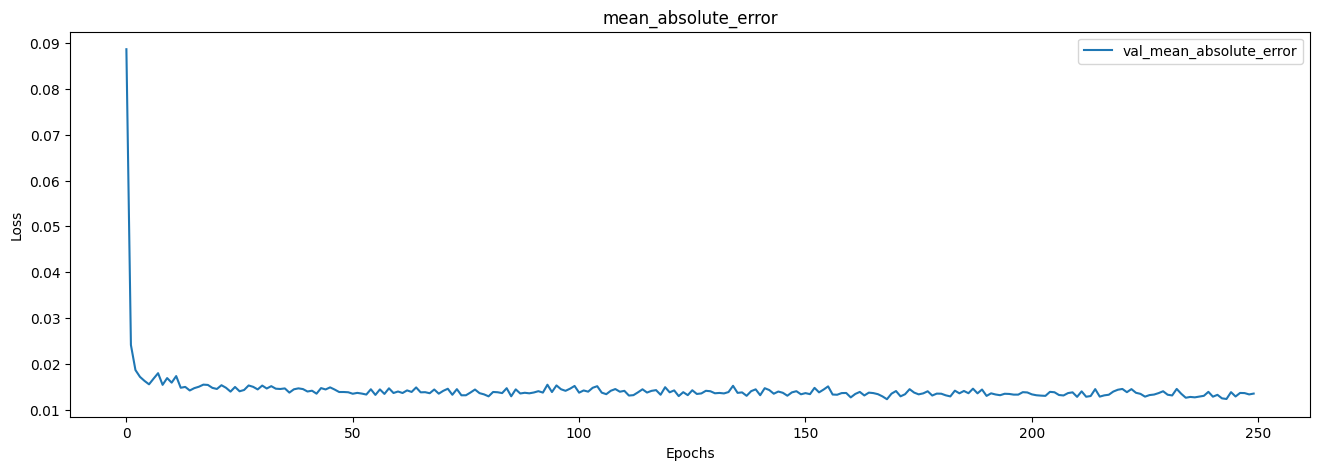

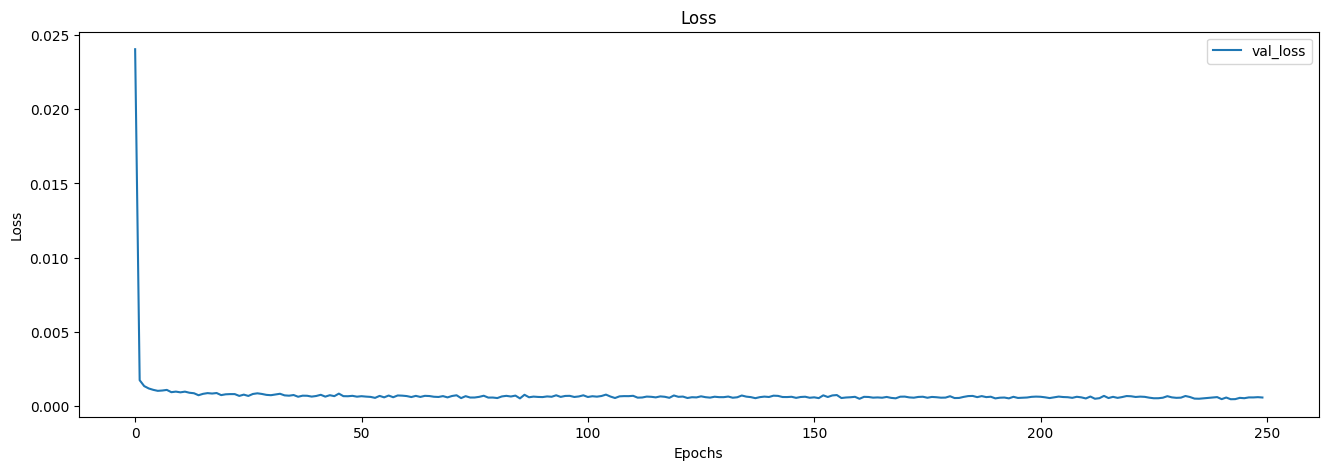

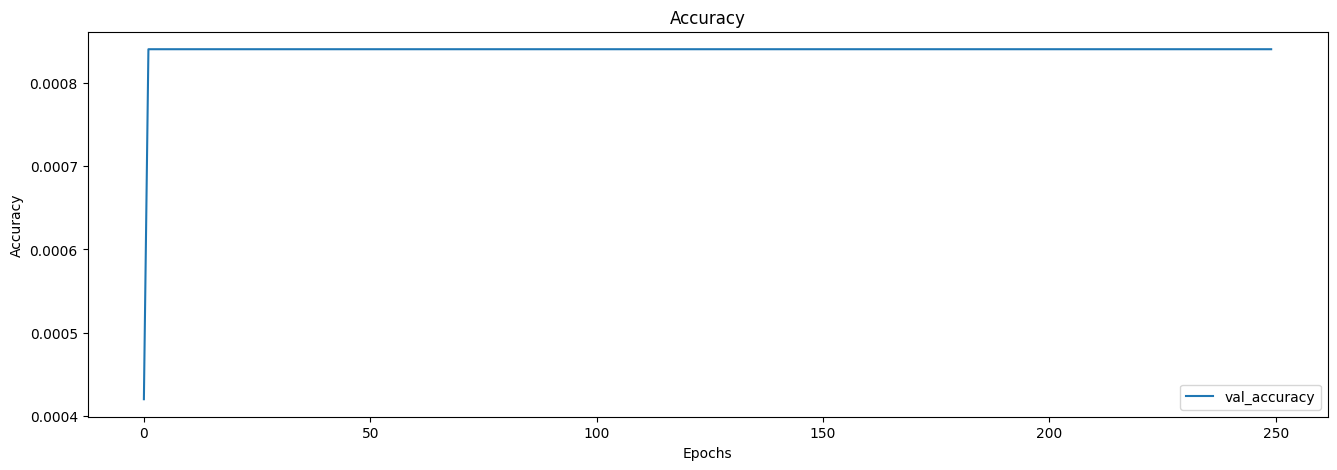

In [19]:
visualize_training_results(history)

In [20]:
# Evaluate the model on the test set
mse , accuracy, mae  = model.evaluate(X_test, y_test)

19/19 [==============================] - 5s 6ms/step - loss: 3.8484e-04 - accuracy: 0.0034 - mean_absolute_error: 0.0154


In [21]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)

# convert to original data 
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)


#evaluat
mse = mean_squared_error(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))



19/19 [==============================] - 4s 5ms/step
y_pred (596, 1)
y_test (596, 1)
MAPE: 2.4880%
RMSE: 1015.7713
MSE: 1031791.4283
MAE:795.2863


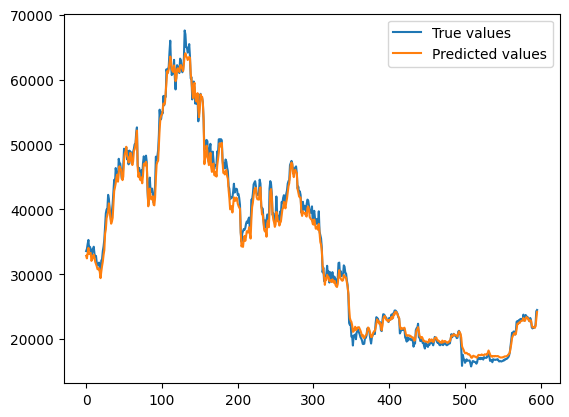

In [23]:
# Plot the true values and predicted values
plt.plot(y_test, label='True values')
plt.plot(y_pred, label='Predicted values')

# Add a legend and show the plot
plt.legend()
plt.show()

In [22]:
y_pred_df = pd.DataFrame(y_pred, columns=[ "Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=[ "Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=prediction_dates, end=today, freq='D')
test_dates = pd.date_range(start=test,end=today, freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)



In [24]:
y_test_df

,Adj Close
Date,
2021-07-04,33572.117188
2021-07-05,33897.046875
2021-07-06,34668.546875
2021-07-07,35287.781250
2021-07-08,33746.003906
...,...
2023-02-15,21788.203125
2023-02-16,21808.101562
2023-02-17,22220.804688


In [25]:
y_pred_df

,Adj Close
Date,
2021-07-04,32841.906250
2021-07-05,32444.757812
2021-07-06,33222.578125
2021-07-07,34065.476562
2021-07-08,33132.316406
...,...
2023-02-15,21883.320312
2023-02-16,21739.681641
2023-02-17,21974.875000


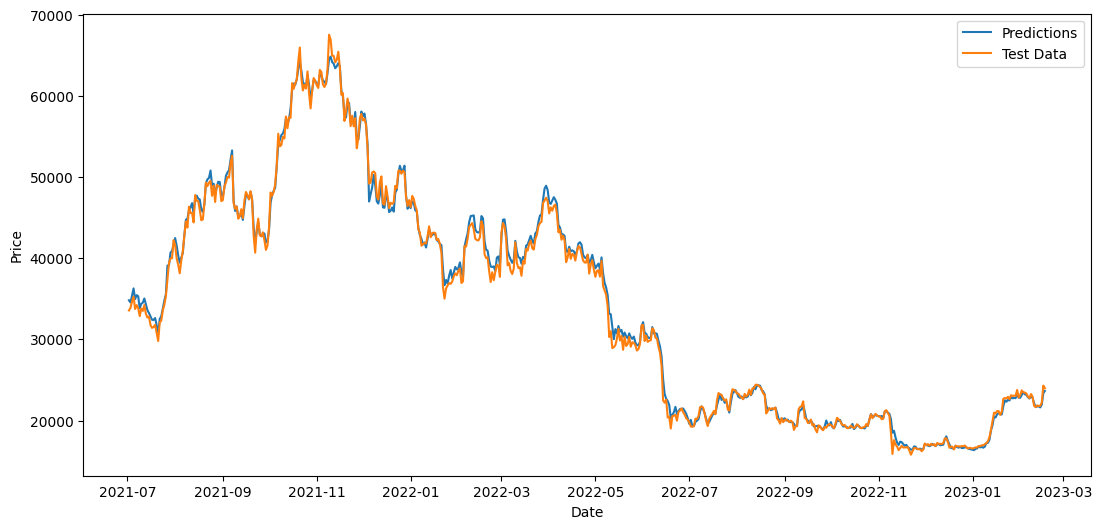

In [22]:
plt.figure(figsize=(13,6))
plt.plot(y_pred_df['Adj Close'], label='Predictions')
plt.plot(y_test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [26]:

names = cycle(['Predictions','Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price', font_size=15, font_color='black',legend_title_text=' Parameters')
fig.show()


In [27]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')



MAPE: 2.4880%


In [28]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))



smape: 2.4886%


In [38]:
data2 = yf.download(tickers='BTC-usd', period='max', interval='1d')
data2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,21788.203125,17821046406
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,21808.101562,23918742607
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,22220.804688,26792596581


In [39]:
# Step 2: Feature engineering
data2['RSI']       = ta.rsi(data2.Close, length=15)
data2['EMA_short'] = ta.ema(data2.Close, length=20)
data2['EMA_long']  = ta.ema(data2.Close, length=100)
data2.dropna(inplace=True)
data2.reset_index(inplace = True)
data2.drop([ 'Close'], axis=1, inplace=True)
# Setting the index
data2.set_index('Date', inplace=True)

# Dropping any NaNs
data2.dropna(inplace=True)

data2.info()
data2.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2014-12-25 to 2023-02-17
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2976 non-null   float64
 1   High       2976 non-null   float64
 2   Low        2976 non-null   float64
 3   Adj Close  2976 non-null   float64
 4   Volume     2976 non-null   int64  
 5   RSI        2976 non-null   float64
 6   EMA_short  2976 non-null   float64
 7   EMA_long   2976 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.2 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-07,22757.267578,23310.974609,22756.257812,23264.291016,27187964471,64.484885,22542.069704,19903.181588
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,25371367758,60.306257,22579.910536,19963.304694
2023-02-09,22946.566406,22996.437500,21773.974609,21819.039062,32572572185,48.656922,22507.446586,20000.051909
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,27078406594,47.193524,22425.897730,20032.747586
2023-02-11,21651.841797,21891.410156,21618.449219,21870.875000,16356226232,49.330527,22373.038422,20069.146149
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,26792596581,53.052268,22264.266059,20178.212065
2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,32483312909,67.728410,22458.892320,20259.986911


In [57]:
future_data = data.iloc[-30:,:]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume","RSI",
                                                 "EMA_short","EMA_long"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start= future_dates , end= today + timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today , periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data= future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

#x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data= scaler.fit_transform(x_future_data)
y_future_data= scaler.fit_transform(y_future_data)
for i in range(10):
 future_data_temp = x_future_data[i:i+30, :]
 #future_data_temp = future_data_temp.reshape(-1, 1)
 print("future_data_temp", future_data_temp.shape)
 
 

x_future_data: (30, 7)
y_future_data: (30, 1)
x_future_data: (30, 7)
future_data_temp (30, 7)
future_data_temp (29, 7)
future_data_temp (28, 7)
future_data_temp (27, 7)
future_data_temp (26, 7)
future_data_temp (25, 7)
future_data_temp (24, 7)
future_data_temp (23, 7)
future_data_temp (22, 7)
future_data_temp (21, 7)


In [58]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    
    print("future_data_temp1", future_data_temp.shape)
    future_data_temp= np.reshape(future_data_temp, (future_data_temp.shape[0],
                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3',future_data.shape)
print('prediction:',prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(prediction, index= future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test,end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)

future_data_temp1 (30, 7)
1/1 [==============================] - 0s 78ms/step
future_data_temp2 (30, 1, 7)
---------------------------------------------------
future_data_temp1 (29, 7)
1/1 [==============================] - 0s 89ms/step
future_data_temp2 (29, 1, 7)
---------------------------------------------------
future_data_temp1 (28, 7)
1/1 [==============================] - 0s 90ms/step
future_data_temp2 (28, 1, 7)
---------------------------------------------------
future_data_temp1 (27, 7)
1/1 [==============================] - 0s 79ms/step
future_data_temp2 (27, 1, 7)
---------------------------------------------------
future_data_temp1 (26, 7)
1/1 [==============================] - 0s 53ms/step
future_data_temp2 (26, 1, 7)
---------------------------------------------------
future_data_temp1 (25, 7)
1/1 [==============================] - 0s 113ms/step
future_data_temp2 (25, 1, 7)
---------------------------------------------------
future_data_temp1 (24, 7)
1/1 [==============

In [59]:
prediction_df

,Adj Close
2023-02-20,20901.309649
2023-02-21,20864.564062
2023-02-22,21544.911045
2023-02-23,22441.292328
2023-02-24,22404.868804
2023-02-25,22597.378974
2023-02-26,22575.062279
2023-02-27,22761.359339
2023-02-28,22868.687507
2023-03-01,22879.688120


In [60]:
y_future_data

,Adj Close
Date,
2023-01-22,20688.781250
2023-01-23,21086.792969
2023-01-24,22676.552734
2023-01-25,22777.625000
2023-01-26,22720.416016
2023-01-27,22934.431641
2023-01-28,22636.468750
2023-01-29,23117.859375
2023-01-30,23032.777344


In [61]:
names = cycle(['Predictions next 10 day','Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price', font_size=15, font_color='black',legend_title_text=' Parameters')
fig.show()

In [31]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y, name='Predictions Data for 10 day'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()

In [62]:
names = cycle(['Predictions','Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))
                         
fig.update_layout(xaxis_title='Date', yaxis_title='Price', font_size=15, font_color='black',legend_title_text=' Parameters')
fig.show()

In [33]:
# Get the last date in the data
last_date = data.index[-1]

# Generate the next 30 days of dates
prediction_dates = pd.date_range(last_date, periods=30, freq='D')[1:]

# Get the most recent sequence of prices from the test data
last_sequence = X_test[-1]

# Reshape the sequence to (1, n_timesteps, n_features)
print('last_sequence',last_sequence.shape)
#last_sequence = last_sequence.reshape((1, last_sequence.shape[1], 1))
last_sequence = np.reshape(last_sequence, (1, last_sequence.shape[0], last_sequence.shape[1]))
# Use the model to predict the next 30 days of prices

predicted_prices = model.predict(last_sequence)


# Extract the first element of the predicted prices
next_price = predicted_prices[0][0]

# Create an array of zeros with a shape of (29, 1)
zeros_array = np.zeros((29, 1))

# Concatenate the next price with the zeros array
predicted_prices = np.concatenate((np.array([[next_price]]), zeros_array))

# Inverse transform the predicted prices
predicted_prices = scaler.inverse_transform(predicted_prices)

# Create a range of 30 days starting from the day after the last day in the training data
#prediction_dates = pd.date_range(last_date + pd.DateOffset(days=1), periods=30, freq='D')

# Create a DataFrame of the predicted prices

predicted_prices = pd.DataFrame(predicted_prices, columns=['Adj Close'], index=pd.date_range(last_date, periods=30, freq='D'))





last_sequence (1, 7)
1/1 [==============================] - 0s 101ms/step


In [34]:
predicted_prices

,Adj Close
2023-02-17,21238.22310
2023-02-18,20688.78125
2023-02-19,20688.78125
2023-02-20,20688.78125
2023-02-21,20688.78125
2023-02-22,20688.78125
2023-02-23,20688.78125
2023-02-24,20688.78125
2023-02-25,20688.78125
2023-02-26,20688.78125


In [35]:
# Step 7: Plot the predicted values
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=predicted_prices.index, y=predicted_prices['Adj Close'], mode='lines', name='Predicted'))
fig.update_layout(title='Bitcoin Price Predictions', xaxis_title='Date', yaxis_title='Price (USD)')
fig.show()

In [36]:
# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = X_test[-30:]
print ("last_five_days", last_five_days.shape )
last_five_days = np.reshape(last_five_days, (last_five_days.shape[0],1, last_five_days.shape[2]))
predictions = []
for i in range(10):
    prediction = model.predict(last_five_days)[0]
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:,1:,:],  [prediction[np.newaxis,:]], axis=1)


last_five_days (30, 1, 7)
1/1 [==============================] - 0s 84ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 30 and the array at index 1 has size 1

In [50]:
# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = np.array(X_test[-30:])
predictions = []
for i in range(10):
    """""
    print(f"last_five_days.shape={last_five_days.shape}")
    prediction = model.predict(last_five_days)[0]
    print(f"prediction.shape={prediction.shape}")
    #prediction = np.squeeze(prediction, axis=0)
    #print(f"prediction.shape={prediction.shape}")
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:,1:,:], [prediction[np.newaxis,:]], axis=1)"""

    prediction = model.predict(last_five_days)
    print(f"prediction.shape1={prediction.shape}")
    prediction = np.reshape(prediction, (prediction.shape[0], 1))
    print(f"prediction.shape2={prediction.shape}")
    predictions.append(prediction)
    prediction = np.expand_dims(prediction, axis=1)
    last_five_days = np.append(last_five_days[:,1:,:], prediction, axis=1)



1/1 [==============================] - 0s 223ms/step
prediction.shape1=(30, 1)
prediction.shape2=(30, 1)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

In [51]:
# Initialize empty list to store predictions
predictions = []

# Iterate over test data
for i in range(len(X_test) - 1):

    # Get the last 5 days of data
    last_five_days = X_test[i:i+1]

    # Reshape last_five_days to match input shape of the model
    last_five_days = np.reshape(last_five_days, (1, 1, 7))

    # Make a prediction
    prediction = model.predict(last_five_days)

    # Append prediction to list of predictions
    predictions.append(prediction)

    # Reshape prediction to match output shape of model
    prediction = np.reshape(prediction, (1, 1, 1))

    # Append prediction to last_five_days
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=1)


1/1 [==============================] - 0s 116ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

In [66]:
# Generate predictions
predictions = []
for i in range(len(X_test)):
    X_test = last_five_days.reshape((1, 1, 7))
    prediction = model.predict(X_test, verbose=1)
    predictions.append(prediction)
    prediction = np.reshape(prediction, (1, 1, 1))
    print ('1- prediction     :',prediction.shape )
    print ('2- last_five_days :', last_five_days.shape)
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=2)

# Convert predictions to array and reshape
predictions = np.array(predictions).reshape(-1, 1)


1/1 [==============================] - 0s 102ms/step
1- prediction     : (1, 1, 1)
2- last_five_days : (1, 1, 7)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 1